In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
import sys
sys.path.append("/home/tobias/projects/hashcode2017")
FILE = "/home/tobias/projects/hashcode2017/stats.pickle"

In [4]:
with open(FILE, 'rb') as fp:
    stats = pickle.load(fp)

In [5]:
len(np.unique(stats._to))

6717

In [6]:
levels = np.sort(np.unique(stats._to + stats._from))

In [7]:
N = len(levels)
N

6718

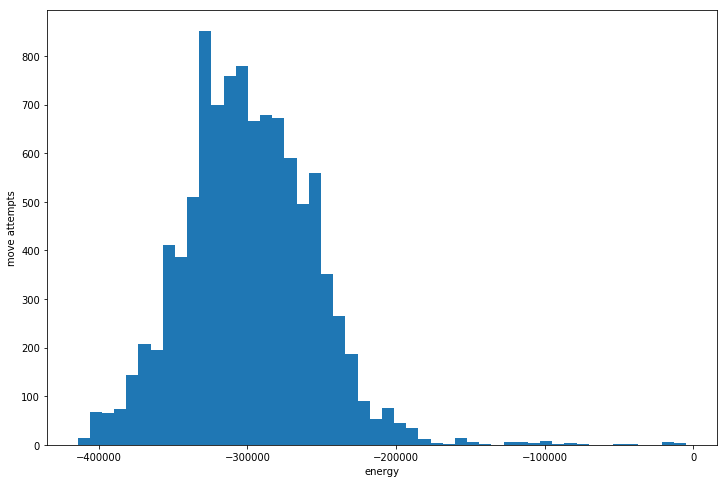

In [210]:
plt.figure(figsize=(12, 8))
h = plt.hist(stats._to, bins=50)
plt.xlabel("energy")
plt.ylabel("move attempts")


In [9]:
n_to = [np.count_nonzero(stats._to == E) for E in levels]


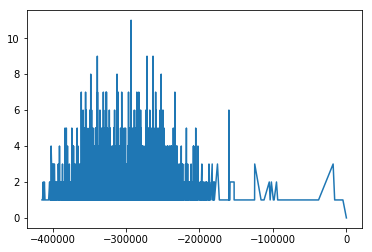

In [10]:
plt.plot(levels, n_to)

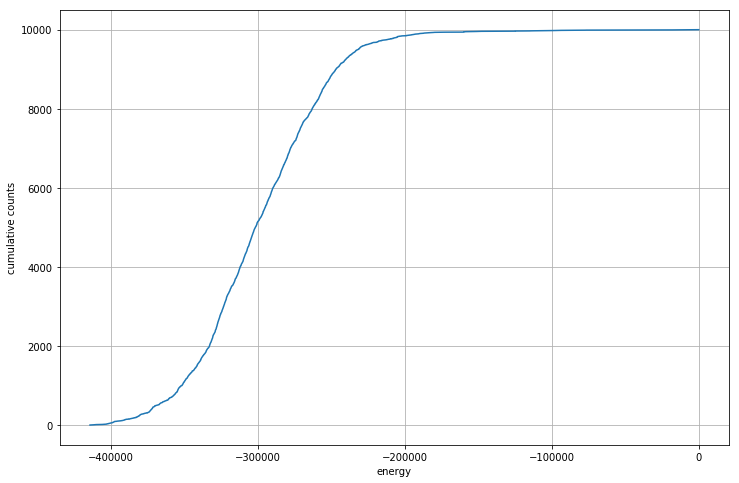

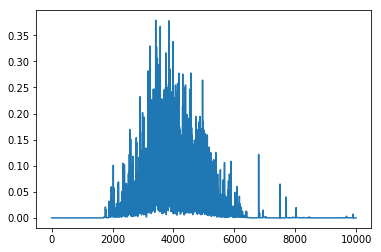

In [212]:
plt.figure(figsize=(12, 8))
cdf = np.cumsum(n_to)
plt.plot(levels, cdf)
plt.xlabel("energy")
plt.ylabel("cumulative counts")
plt.grid()

e = np.linspace(-5e5, 0, 10000)
cdf_e = np.interp(e, levels, cdf)

pdf = np.diff(cdf_e) / (e[1] - e[0])

plt.figure()
plt.plot(pdf)

In [13]:
NPAR = 100

lumps_n = np.linspace(0, cdf.max(), NPAR)
lumps_E = np.interp(lumps_n, cdf, levels)

print(lumps_n)
print(lumps_E)


[     0.            101.01010101    202.02020202    303.03030303
    404.04040404    505.05050505    606.06060606    707.07070707
    808.08080808    909.09090909   1010.1010101    1111.11111111
   1212.12121212   1313.13131313   1414.14141414   1515.15151515
   1616.16161616   1717.17171717   1818.18181818   1919.19191919
   2020.2020202    2121.21212121   2222.22222222   2323.23232323
   2424.24242424   2525.25252525   2626.26262626   2727.27272727
   2828.28282828   2929.29292929   3030.3030303    3131.31313131
   3232.32323232   3333.33333333   3434.34343434   3535.35353535
   3636.36363636   3737.37373737   3838.38383838   3939.39393939
   4040.4040404    4141.41414141   4242.42424242   4343.43434343
   4444.44444444   4545.45454545   4646.46464646   4747.47474747
   4848.48484848   4949.49494949   5050.50505051   5151.51515152
   5252.52525253   5353.53535354   5454.54545455   5555.55555556
   5656.56565657   5757.57575758   5858.58585859   5959.5959596
   6060.60606061   6161.61

In [36]:
P = np.zeros((NPAR, NPAR))

for e0, e1 in zip(stats._from, stats._to):
    i0 = np.argmax(lumps_E > e0) - 1
    i1 = np.argmax(lumps_E > e1) - 1
    P[i0, i1] += 1

P = P / P.sum(axis=0)
P[np.isnan(P)] = 0

/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


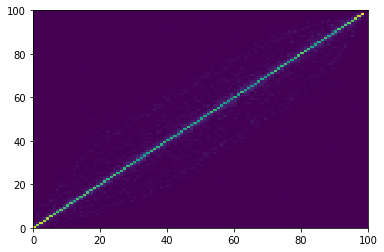

In [37]:
plt.pcolormesh(P[:, :])

In [39]:
dE = lumps_E[:, None] - lumps_E

In [65]:
G

array([[  8.61386139e-01,   1.46896200e-02,   8.30671232e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.34073213e-01,   7.42574257e-01,   1.95959029e-02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.08075117e-01,   2.45125252e-01,   8.21782178e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          8.10000000e-01,   1.76215675e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.47103335e-01,   9.02912621e-01,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   1.80282479e+06,   0.00000000e+00]])

In [71]:
ev_order[:5]

[1, 2, 3, 4, 5]

In [110]:
def get_G(matP, T):
    if np.isinf(T):
        B = 1
    else:
        B = np.exp(dE / T)
    return matP * B

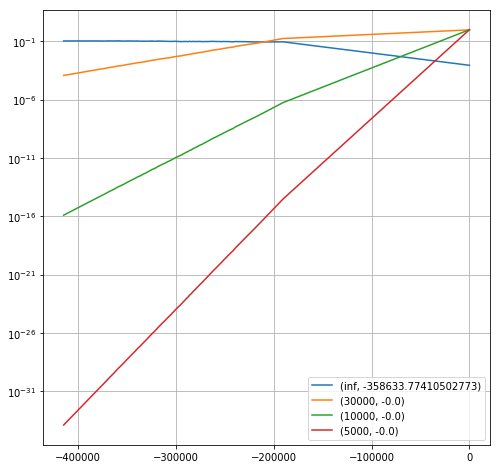

In [227]:
plt.figure(figsize=(8, 8))
for T in [np.inf, 30000, 10000, 5000]:
    G = get_G(P, T)
    evals, evecs = np.linalg.eig(G)
    ev_order = sorted(np.arange(len(evals)), key=lambda i: np.real(evals[i]))[::-1]
    p = abs(evecs[:, ev_order[0]])
    plt.semilogy(lumps_E, p, label=(T, lumps_E[np.argmax(p)]))
plt.legend()
plt.grid()

In [118]:
def get_lambda2(G):
    """
    Return 2nd-largest eigenvalue of G
    """
    evals, evecs = np.linalg.eig(G)
    ev_order = sorted(np.arange(len(evals)), key=lambda i: np.real(evals[i]))[::-1]
    return evals[ev_order[1]].real

def relaxation_time(P, T):
    G = get_G(P, T)
    l2 = get_lambda2(G)
    return -1 / np.log(l2)

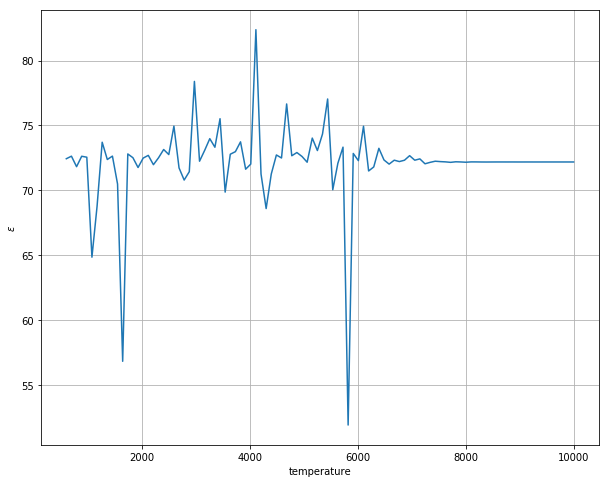

In [230]:
plt.figure(figsize=(10,8))
temps = np.linspace(600, 10000, 100)
eps = [relaxation_time(P, T) for T in temps]
plt.plot(temps, eps)
plt.grid()
plt.xlabel("temperature")
plt.ylabel("$\\epsilon$")


In [258]:
evals, evecs = np.linalg.eig(P)
i = np.argmax(evals.real)
p = evecs[:, i]

Z = lambda T: np.real(np.sum(p * np.exp(-lumps_E / T)))

In [259]:
dZ = lambda T: np.real(np.sum(lumps_E * p * np.exp(-lumps_E / T))) / T ** 2
#ddZ = lambda T: (2 * Z(T) + np.real(np.sum(lumps_E ** 2 * p * np.exp(lumps_E / T)))) / T ** 3
ddZ = lambda T: -2 * dZ(T) / T + (1 / T ** 4) * np.real(np.sum(lumps_E ** 2 * p * np.exp(-lumps_E / T)))
dlogZ = lambda T: dZ(T) / Z(T)
ddlogZ = lambda T: (ddZ(T) * Z(T) - dZ(T) ** 2) / (Z(T) ** 2)

In [260]:
E = lambda T: T ** 2 * dlogZ(T)
C = lambda T: 2 * T * dlogZ(T) + T ** 2 * ddlogZ(T)

/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in double_scalars
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in square


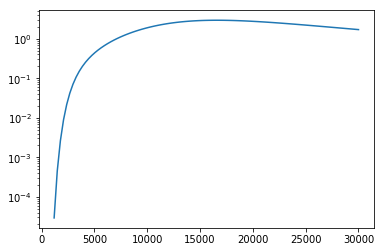

In [264]:
temps = np.linspace(600, 30000, 100)
c = np.asarray([C(T) for T in temps])
c = np.ma.masked_invalid(c)
plt.semilogy(temps, c)


In [283]:
Tdot_by_T = lambda v, T: -v / (relaxation_time(P, T) * np.sqrt(C(T)))

/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in double_scalars
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in square


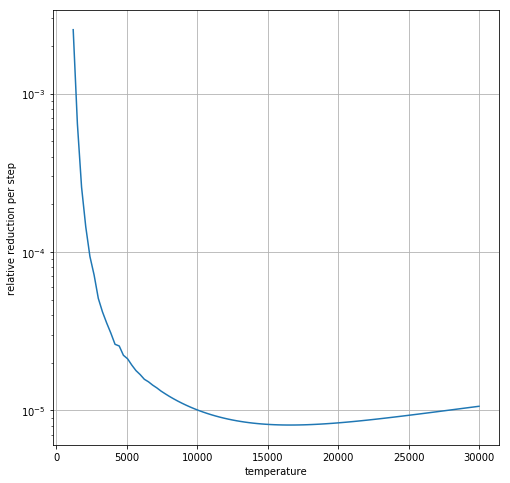

In [284]:
plt.figure(figsize=(8, 8))
Tdot = [Tdot_by_T(1e-3, T) for T in temps]
Tdot = np.asarray(Tdot)
Tdot = np.ma.masked_invalid(Tdot)
plt.semilogy(temps, -Tdot)
plt.xlabel("temperature")
plt.ylabel("relative reduction per step")
plt.grid()

In [300]:
from scipy.integrate import odeint

eps = lambda y: relaxation_time(P, np.exp(y))
cap = lambda y: C(np.exp(y))

f = lambda y, t, v: -v / (eps(y) * np.sqrt(cap(y)))

T0 = 10000
times = np.arange(0, 20000)

y0 = np.log(T0)

for v in [0.005]:
    y_sol = odeint(f, y0, times, args=(v,))
    plt.plot(times, np.exp(y_sol), label="%.2e" % v)
plt.legend()
plt.grid()



KeyboardInterrupt: 

/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


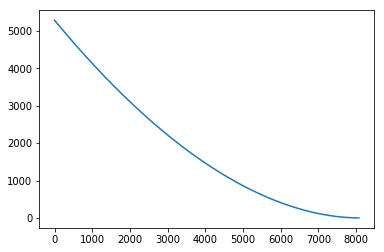

In [253]:
E_sol = np.ma.masked_invalid(np.asarray([E(T) for T in T_sol]))
plt.plot(times, E_sol)
#print(E_sol)

/home/tobias/venv/py3/lib/python3.4/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


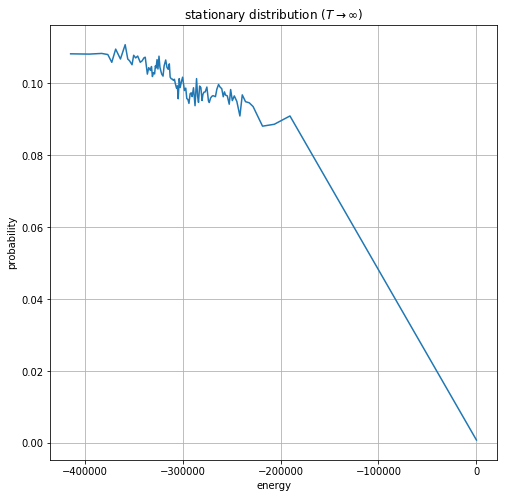

In [223]:
evals, evecs = np.linalg.eig(P)
i = np.argmax(evals.real)
p = evecs[:, i]
plt.figure(figsize=(8, 8))
plt.plot(lumps_E, p)
plt.grid()
plt.xlabel("energy")
plt.ylabel("probability")
plt.title("stationary distribution ($T\\rightarrow\\infty$)")

In [242]:
E(T_sol[0])

array([ 5284.70841674])

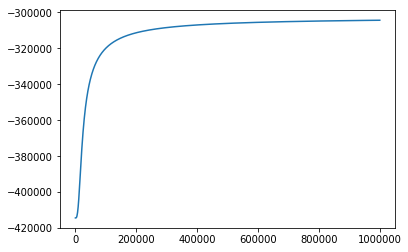

In [262]:
temps = np.linspace(1000, 1e6, 1000)
e = np.asarray([E(T) for T in temps])
plt.plot(temps, e)

NaN rate. Stop integration at step 8455


/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in double_scalars
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in square


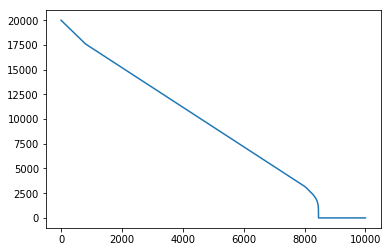

In [342]:
T0 = 20000

times = np.arange(10000)
V = 1.4e-2
recompute = True
counter = 0
T_sol = np.zeros_like(times)
T_sol[0] = T0
abort = False

for i, t in enumerate(times[1:]):
    T = T_sol[i]
    if not counter:
        try:
            e = relaxation_time(P, T)
        except np.linalg.LinAlgError:
            print("Error in EV computation. Stop integration at step %d." % i)
            abort = True
        if not abort:
            c = C(T)
            rate = V / (e * np.sqrt(c)) * T
            counter = int(e / 10)    
    if abort:
        break
    if np.isnan(rate):
        print("NaN rate. Stop integration at step %d" % i)
        break
    if T <= rate:
        T_sol[1 + i] = 0
        break
    T_sol[1 + i] = T - rate
    counter -= 1

plt.plot(times, T_sol)

/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply
/home/tobias/venv/py3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in double_sca

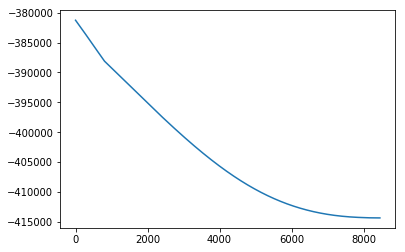

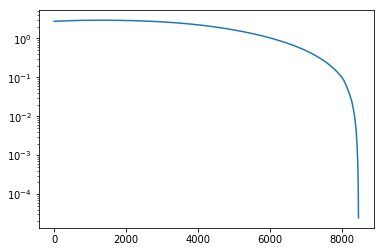

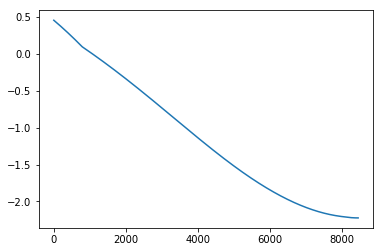

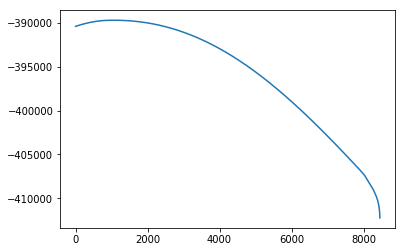

In [343]:
S = lambda T: np.log(Z(T)) + T * dlogZ(T)

en = np.asarray([E(T) for T in T_sol])
en = np.ma.masked_invalid(en)
plt.plot(times, en)

plt.figure()
en = np.asarray([C(T) for T in T_sol])
en = np.ma.masked_invalid(en)
plt.semilogy(times, en)

plt.figure()
en = np.asarray([S(T) for T in T_sol])
en = np.ma.masked_invalid(en)
plt.plot(times, en)

plt.figure()
en = np.asarray([-T * np.log(Z(T)) for T in T_sol])
en = np.ma.masked_invalid(en)
plt.plot(times, en)